In [1]:
import torch
import os
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image
from safetensors.torch import load_model

In [7]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        This module applies two consecutive convolutional layers to the input.
        
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
        """
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        """Forward pass of the DoubleConv module."""
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512, 1024]):
        """
        Basic U-Net model for image to image
        
        Args:
            in_channels (int, optional): Number of input channels.
            out_channels (int, optional): Number of output channels.
            features (list, optional): List of features for encoding and decoding.
        """
        super(UNet, self).__init__()

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        """Forward pass of the U-Net model"""
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]

            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i+1](concat_skip)

        x = self.final_conv(x)

        return x

In [2]:
def get_url_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

In [3]:
def display_image(image_array):
    # Convert from channels-first to channels-last
    image_array = image_array = image_array[0].numpy().transpose(1, 2, 0)
    
    plt.imshow(image_array)
    plt.axis('off')
    plt.show()

In [4]:
image_transforms = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.CenterCrop(512),
        transforms.ToTensor()
    ]
)

# Gets the best device to load the model to
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = UNet()
model.to(device)
model.eval()
load_model(model, "tattoo_remover.safetensors")

(set(), [])

torch.Size([1, 3, 512, 512])


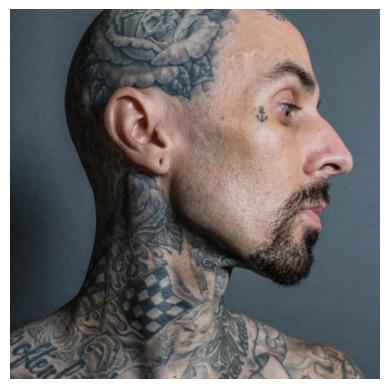

In [5]:
url = "https://media.gq.com/photos/57b643441890ff58025997be/master/w_1600%2Cc_limit/travis-barker-gq-19.jpg"
image = get_url_image(url)
input = image_transforms(image)
input = torch.unsqueeze(input, 0)

display_image(input)

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


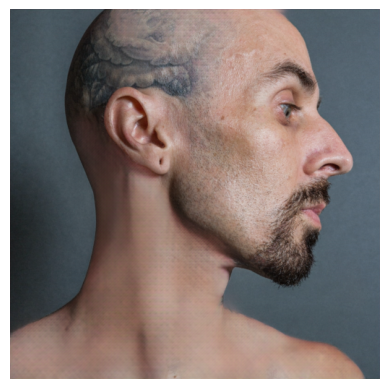

In [6]:
# Forward the image through the model
with torch.no_grad():
    input = input.to(device)
    output = model(input)

display_image(output.cpu())